# Exercise 1 - Download, read and visualize H-SAF ASCAT SSM CDR and ISMN data

## Importing packages
Here we first import the python packages which we will need throughout this exercise. Don't worry about the warnings. 

In [1]:
import os, glob, sys  # Miscellaneous operating system interfaces
import pandas as pd  # Python data analysis library for working with data frames and basic analysis
import numpy as np
import ascat.h_saf as hsaf  # Package for reading hsaf data
import matplotlib.pyplot as plt  # Plotting library
from ismn.interface import ISMN_Interface  # Package for reading ISMN data
import pytesmo.temporal_matching as tmatch  # Package for temporal matching of two time series
import pytesmo.time_series.anomaly as ts_anom  # Package for time series analysis and validation
import ascat.read_native.ragged_array_ts as rat
from pathlib import Path
import xarray as xr
import zarr


/home/ljovic/miniconda3/envs/dreo_environment/lib/python3.10/site-packages/ascat/h_saf.py:41: UserWarning: pygrib can not be imported GRIB files (H14) can not be read.
  warnings.warn(


## Set paths for data
Here we need to set the paths to where the data is stored. If you have stored all the data to the same folder, you will only need to change the path_test_data variable to your data folder. 

In [6]:
# change the username of the paths
#path_test_data = f"/home/ljovic/Desktop/Data Retrieval in Earth Observation/Data"
#workspace_path = f"/home/ljovic/Desktop/Data Retrieval in Earth Observation"
#print(os.path.isdir(path_test_data))  # check if the path is correct
#print(os.path.isdir(workspace_path))  # check if the path is correct
#h120_path = os.path.join(path_test_data, "hsaf")
#static_layer_path = os.path.join(path_test_data, "static_layer")
#grid_path = os.path.join(path_test_data, "warp5_grid")
# i created a folder ismn
#ismn_path = os.path.join(workspace_path, "ismn")


True
True


In [121]:

path_test_data = Path("/home/ljovic/Desktop/Data Retrieval in Earth Observation/Data")

workspace_path = Path("/home/ljovic/Desktop/Data Retrieval in Earth Observation")

h120_path = path_test_data / "hsaf"
static_layer_path = path_test_data / "static_layer"
grid_path = path_test_data / "warp5_grid"

ismn_path = workspace_path / "ismn"

print("Path to the test data exists:", path_test_data.exists())
print("Path to the workspace exists:", workspace_path.exists())
print("Path to the hsaf data exists:", h120_path.exists())
print("Path to the statis layers files exists:", static_layer_path.exists())
print("Path to the grid files exists:", grid_path.exists())
print("Path to the ISMN data exists:", ismn_path.exists())

Path to the test data exists: True
Path to the workspace exists: True
Path to the hsaf data exists: True
Path to the statis layers files exists: True
Path to the grid files exists: True
Path to the ISMN data exists: True


In [ ]:
cell_source = Path(
    "/home/ljovic/shares/radar/DataLab/sync_with_datalab/datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
)
cell_source.exists()

## Read ISMN Data

To read ISMN data there is a package available on github, which is already installed here. A description and examples can be found here: https://ismn.readthedocs.io/en/latest/examples/interface.html

In the following cells we give you an example of how to read the data. The first time your data will be unzipped and takes a bit longer. 

In [95]:
# Either a .zip file or one folder that contains all networks, here we read from .zip
data_path = "/home/ljovic/Desktop/Data Retrieval in Earth Observation/ismn/Data_separate_files_header_20150224_20250224_11904_gvo0_20250224.zip"
ismn_data = ISMN_Interface(data_path, parallel=False)

Using the existing ismn metadata in /home/ljovic/Desktop/Data Retrieval in Earth Observation/ismn/python_metadata/Data_separate_files_header_20150224_20250224_11904_gvo0_20250224.csv to set up ISMN_Interface. 
If there are issues with the data reader, you can remove the metadata csv file to repeat metadata collection.


In [96]:
dir(ismn_data)

['_ISMN_Interface__file_collection',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_collect',
 'activate_network',
 'climate',
 'close_files',
 'collection',
 'custom_meta_reader',
 'find_nearest_station',
 'force_metadata_collection',
 'get_climate_types',
 'get_dataset_ids',
 'get_landcover_types',
 'get_min_max_obs_timestamps',
 'get_static_var_vals',
 'get_variables',
 'grid',
 'keep_loaded_data',
 'landcover',
 'list_networks',
 'list_sensors',
 'list_stations',
 'meta_path',
 'metadata',
 'network_for_station',
 'networks',
 'parallel',
 'plot_station_locations',
 'print_climate_dict',
 'print_landcover_dict',
 'read',
 'read_metadata',
 'read_

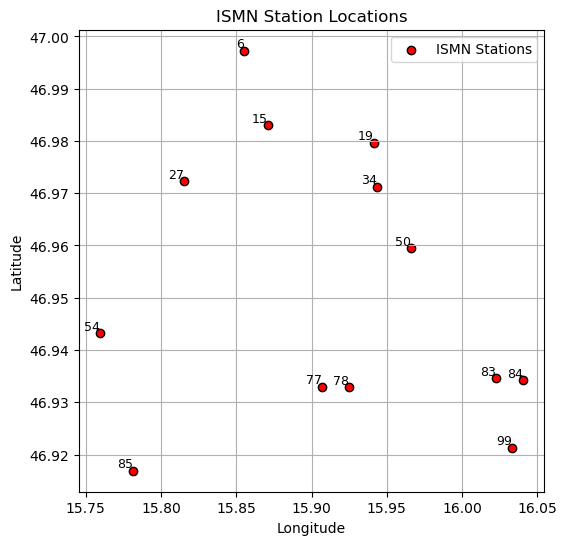

In [97]:
station_ids = []
lats = []
lons = []

for station in ismn_data.stations_that_measure("soil_moisture"):
    station_ids.append(station.name)
    lats.append(station.lat)
    lons.append(station.lon)

plt.figure(figsize=(6, 6))
plt.scatter(lons, lats, marker="o", c="red", edgecolors="black", label="ISMN Stations")

for i, station_id in enumerate(station_ids):
    plt.text(lons[i], lats[i], station_id, fontsize=9, ha="right", va="bottom")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("ISMN Station Locations")
plt.legend()
plt.grid(True)
plt.show()


In [98]:
# Loop through each station that measures soil moisture
for station in ismn_data.stations_that_measure("soil_moisture"):
    print(f"\n Station '{station.name}' has the following sensors:\n")

    for sensor in station.sensors:
        print(f"   - {sensor}")

    print("_" * 60)  # Separator line for readability


 Station '15' has the following sensors:

   - PT1000_soil_temperature_0.300000_0.300000
   - 7041.0000-Rain-Gauge_precipitation_-1.500000_-1.500000
   - PT1000_air_temperature_-2.000000_-2.000000
   - Hydraprobe-II_soil_temperature_0.200000_0.200000
   - pF-Meter-B_soil_moisture_0.300000_0.300000
   - Hydraprobe-II_soil_moisture_0.200000_0.200000
____________________________________________________________

 Station '19' has the following sensors:

   - 7041.0000-Rain-Gauge_precipitation_-1.500000_-1.500000
   - PT1000_air_temperature_-2.000000_-2.000000
   - Hydraprobe-II_soil_moisture_0.200000_0.200000
   - Hydraprobe-II_soil_temperature_0.200000_0.200000
____________________________________________________________

 Station '27' has the following sensors:

   - PT1000_soil_temperature_0.300000_0.300000
   - 7041.0000-Rain-Gauge_precipitation_-1.500000_-1.500000
   - PT1000_air_temperature_-2.000000_-2.000000
   - Hydraprobe-II_soil_temperature_0.200000_0.200000
   - pF-Meter_soil_

In [99]:
station_id = 54  # integer in the case of this network
ismn_data["WEGENERNET"].stations.get(station_id)

Station '54' with Sensors: ['PT1000_soil_temperature_0.300000_0.300000', 'pF-Meter_soil_moisture_0.300000_0.300000', '7041.0000-Rain-Gauge_precipitation_-1.500000_-1.500000', 'PT1000_air_temperature_-2.000000_-2.000000', 'Hydraprobe-II_soil_moisture_0.200000_0.200000', 'Hydraprobe-II_soil_temperature_0.200000_0.200000']

In [100]:
insitu_ds = (
    ismn_data["WEGENERNET"]
    .stations.get(station_id)["Hydraprobe-II_soil_moisture_0.200000_0.200000"]
    .to_xarray()
)
insitu_ds = insitu_ds.squeeze()
insitu_ds

<xarray.Dataset> Size: 2MB
Dimensions:                  (date_time: 69376)
Coordinates:
  * date_time                (date_time) datetime64[ns] 555kB 2017-03-10T16:0...
Data variables: (12/25)
    soil_moisture            (date_time) float64 555kB 0.43 0.427 ... 0.3708
    soil_moisture_flag       (date_time) object 555kB 'G' 'G' 'G' ... 'G' 'G'
    soil_moisture_orig_flag  (date_time) object 555kB 'M' 'M' 'M' ... 'M' 'M'
    depth_from               float64 8B 0.2
    depth_to                 float64 8B 0.2
    clay_fraction            float64 8B 20.0
    ...                       ...
    saturation               float64 8B 0.44
    silt_fraction            float64 8B 38.0
    station                  int64 8B 54
    timerange_from           datetime64[ns] 8B 2017-03-10T16:00:00
    timerange_to             datetime64[ns] 8B 2025-02-23T23:00:00
    variable                 <U13 52B 'soil_moisture'

Let's plot data quickly with xarray.

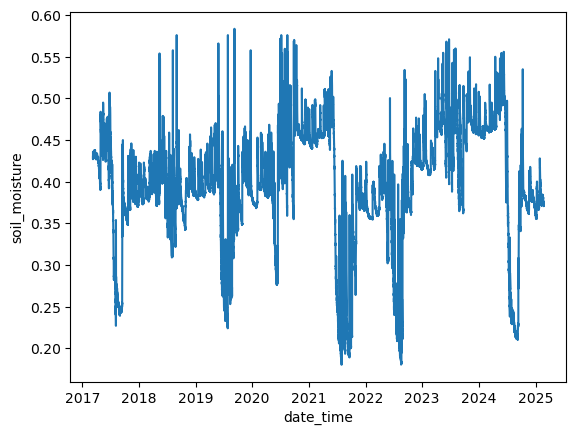

In [101]:
insitu_ds.soil_moisture.plot()

In [102]:
meta = ismn_data["WEGENERNET"].stations.get(station_id).metadata
meta.to_pd()  # let's display metadata in form of dataframe, so it is easier to read

variable        key       
clay_fraction   val                       20.0
                depth_from                 0.0
                depth_to                   0.3
climate_KG      val                        Dfb
climate_insitu  val                    unknown
                                    ...       
variable        depth_from                 0.2
                depth_to                   0.2
                val           soil_temperature
                depth_from                 0.2
                depth_to                   0.2
Name: data, Length: 65, dtype: object

Save location information.

In [103]:
lon = ismn_data.metadata.longitude.val
lat = ismn_data.metadata.latitude.val

In [104]:
from pathlib import Path

h120_path = (
    Path.home()
    / "shares/radar/DataLab/sync_with_datalab/datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
)
h120_path.exists()


True

In [105]:
# change the username of the paths
path_test_data = f"/home/ljovic/Desktop/Data Retrieval in Earth Observation/Data"
workspace_path = f"/home/ljovic/Desktop/Data Retrieval in Earth Observation"
print(os.path.isdir(path_test_data))  # check if the path is correct
print(os.path.isdir(workspace_path))  # check if the path is correct
h120_path = os.path.join(path_test_data, "hsaf")
static_layer_path = os.path.join(path_test_data, "static_layer")
grid_path = os.path.join(path_test_data, "warp5_grid")
# i created a folder ismn
ismn_path = os.path.join(workspace_path, "ismn")


True
True


In [106]:
h120_reader = hsaf.AscatSsmDataRecord(
    h120_path, grid_path=grid_path, static_layer_path=static_layer_path
)
print(h120_reader.path)
h120_ts = h120_reader.read(float(lon.iloc[0]), float(lat.iloc[0]))
h120_ts.head()

/home/ljovic/Desktop/Data Retrieval in Earth Observation/Data/hsaf


,sm,sm_noise,dir,ssf,sat_id,proc_flag,corr_flag,conf_flag,slope40,slope40_noise,curvature40,curvature40_noise,sigma40,sigma40_noise,snow_prob,frozen_prob,abs_sm_gldas,abs_sm_noise_gldas,abs_sm_hwsd,abs_sm_noise_hwsd
2007-01-01 19:24:24.374984,69.720001,4.01,0,2,3,0,0,1,-0.105666,0.000685,-0.001494,0.000069,-7.840000,0.097,22,54,NaN,NaN,NaN,NaN
2007-01-02 19:03:48.749982,35.149998,4.52,0,2,3,0,0,1,-0.105694,0.000689,-0.001480,0.000069,-8.695001,0.108,22,64,NaN,NaN,NaN,NaN
2007-01-03 20:23:07.499991,1.360000,4.46,0,2,3,0,0,1,-0.105769,0.000693,-0.001462,0.000070,-9.539001,0.104,11,54,NaN,NaN,NaN,NaN
2007-01-04 08:37:11.249990,20.869999,4.19,1,2,3,0,0,1,-0.105824,0.000697,-0.001448,0.000070,-9.062000,0.099,22,50,NaN,NaN,NaN,NaN
2007-01-06 09:35:52.500012,56.219997,4.15,1,2,3,0,0,1,-0.106042,0.000705,-0.001415,0.000071,-8.197001,0.102,22,43,NaN,NaN,NaN,NaN


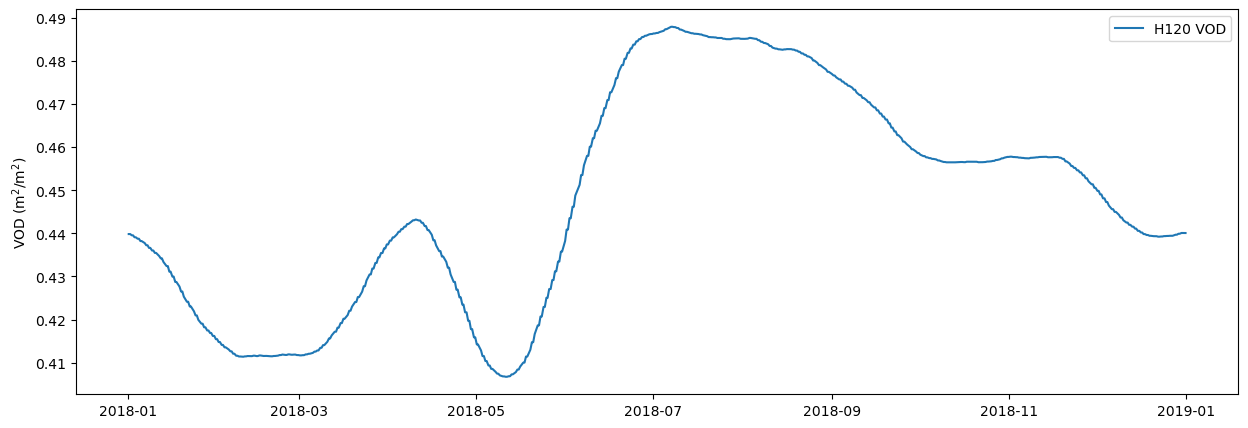

In [107]:
# convert all backscatter to the dry reference cross over angle of 25
sig25 = (
    h120_ts.sigma40
    + h120_ts.slope40 * (25 - 40)
    + 0.5 * h120_ts.curvature40 * (25 - 40) ** 2.0
)
# get the lowest backscatter
dry_25 = np.percentile(sig25, 5)
# convert to the reference angle of 40
dry_ref = (
    dry_25 - h120_ts.slope40 * (25 - 40) - 0.5 * h120_ts.curvature40 * (25 - 40) ** 2
)
# get the wet reference
wet_ref = np.percentile(h120_ts.sigma40, 95)

# set bare soil sensitivity
lin_bs_sens = 0.21

# convert to linear domain
lin_wet_ref = 10 ** (wet_ref / 10.0)
lin_dry_ref = 10 ** (dry_ref / 10.0)

# get total backscatter sensitivity
lin_sens = lin_wet_ref - lin_dry_ref
inc_angle = -np.cos(np.radians(40)) / 2.0
# calculate vod as ratio between bare soil sensitivity and total backscatter sensitivity
# and store it in the h120 dataframe

h120_ts.loc[:, "vod"] = inc_angle * np.log(lin_sens / lin_bs_sens)
# show time series of VOD
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts.loc["2018", "vod"], label="H120 VOD")
ax.set_ylabel(r"VOD (m$^2$/m$^2$)")
ax.legend()
plt.show()

<Axes: >

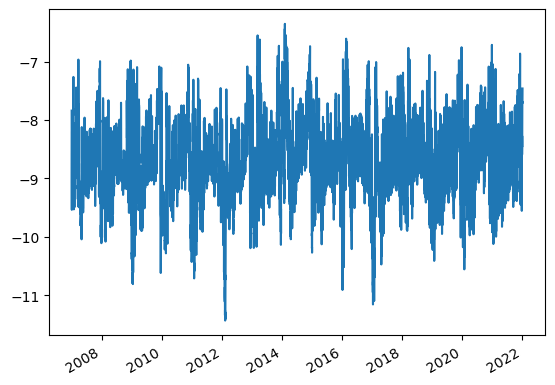

In [108]:
h120_ts.sigma40.plot()

## Read H120 - Metop ASCAT SSM CDR 12.5 km sampling
We need to initialize the reader, where we need to set the paths of the data, the grid file and the static layers. 

Then the data can be read using either longitude and latitude or per gridpoint. You can find the grid of the H120 product here: 
http://rs.geo.tuwien.ac.at/dv/dgg/

The hsaf package automatically reads the data as a pandas dataframe. Now you can use the full functionality of pandas to do a first analysis of your dataset. 
You can have a quick look at the data by using the .head() function, showing you the data structure. For the meaning of the different columns have a look at the Product User Manual: http://hsaf.meteoam.it/documents/PUM/ASCAT_SSM_CDR_PUM_v0.8.pdf
Most important for getting to know the dataset are the columns 'sm'. 

In [109]:
cell_source = Path(
    "/home/ljovic/shares/radar/DataLab/sync_with_datalab/datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
)
cell_source.exists()

True

In [110]:
cell_collection = rat.CellFileCollection.from_product_id(cell_source, "H121_V1.0")

/home/ljovic/miniconda3/envs/dreo_environment/lib/python3.10/site-packages/ascat/read_native/ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ascat_ssm_cdr_12' from directory name. Using min/max datetime from files instead.
  warnings.warn(


Let's read the data and plot.

In [111]:
h120_reader = hsaf.AscatSsmDataRecord(
    h120_path, grid_path=grid_path, static_layer_path=static_layer_path
)
print(h120_reader.path)
h120_ts = h120_reader.read(float(lon.iloc[0]), float(lat.iloc[0]))
h120_ts.head()

/home/ljovic/Desktop/Data Retrieval in Earth Observation/Data/hsaf


,sm,sm_noise,dir,ssf,sat_id,proc_flag,corr_flag,conf_flag,slope40,slope40_noise,curvature40,curvature40_noise,sigma40,sigma40_noise,snow_prob,frozen_prob,abs_sm_gldas,abs_sm_noise_gldas,abs_sm_hwsd,abs_sm_noise_hwsd
2007-01-01 19:24:24.374984,69.720001,4.01,0,2,3,0,0,1,-0.105666,0.000685,-0.001494,0.000069,-7.840000,0.097,22,54,NaN,NaN,NaN,NaN
2007-01-02 19:03:48.749982,35.149998,4.52,0,2,3,0,0,1,-0.105694,0.000689,-0.001480,0.000069,-8.695001,0.108,22,64,NaN,NaN,NaN,NaN
2007-01-03 20:23:07.499991,1.360000,4.46,0,2,3,0,0,1,-0.105769,0.000693,-0.001462,0.000070,-9.539001,0.104,11,54,NaN,NaN,NaN,NaN
2007-01-04 08:37:11.249990,20.869999,4.19,1,2,3,0,0,1,-0.105824,0.000697,-0.001448,0.000070,-9.062000,0.099,22,50,NaN,NaN,NaN,NaN
2007-01-06 09:35:52.500012,56.219997,4.15,1,2,3,0,0,1,-0.106042,0.000705,-0.001415,0.000071,-8.197001,0.102,22,43,NaN,NaN,NaN,NaN


In [113]:
h120_ds = cell_collection.read(
    coords=(float(lon.iloc[0]), float(lat.iloc[0]))
).swap_dims({"obs": "time"})
h120_ds

<xarray.Dataset> Size: 672kB
Dimensions:                            (time: 12682)
Coordinates:
    lon                                float32 4B ...
    lat                                float32 4B ...
    alt                                float32 4B ...
  * time                               (time) datetime64[ns] 101kB 2007-01-02...
Data variables: (12/21)
    locationIndex                      (time) int64 101kB ...
    location_id                        int64 8B ...
    location_description               <U1 4B ...
    as_des_pass                        (time) int8 13kB ...
    swath_indicator                    (time) int8 13kB ...
    surface_flag                       (time) uint8 13kB ...
    ...                                 ...
    snow_cover_probability             (time) int8 13kB ...
    frozen_soil_probability            (time) int8 13kB ...
    wetland_fraction                   (time) int8 13kB ...
    topographic_complexity             (time) int8 13kB ...
    subsurface_scattering_probability  (time) int8 13kB ...
    sat_id                             (time) int8 13kB ...
Attributes:
    id:            1641.nc
    date_created:  2025-01-09 13:41:02
    featureType:   timeSeries

Let's plot all availalble data for this station's location.

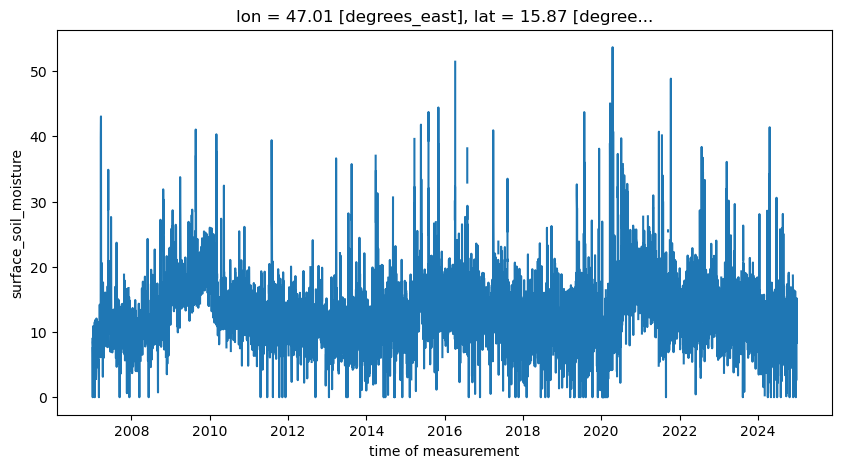

In [114]:
h120_ds.surface_soil_moisture.plot(figsize=(10, 5))

## Plot H120 Soil Moisture data
Now that we have loaded the data we can have a first look at the time series.Soil moisture is available as percentage saturation. If you wish to calculate absolute soil moisture values, a possibility is to multiply the soil moisture data with the porosity value which is stored. 

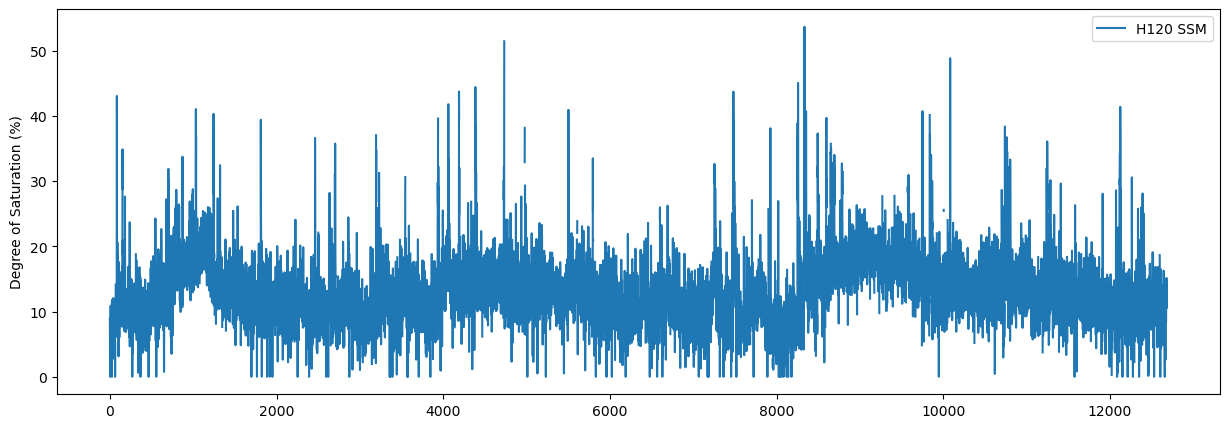

In [115]:
# show complete time series
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ds.surface_soil_moisture, label="H120 SSM")
ax.set_ylabel("Degree of Saturation (%)")
ax.legend()
plt.show()

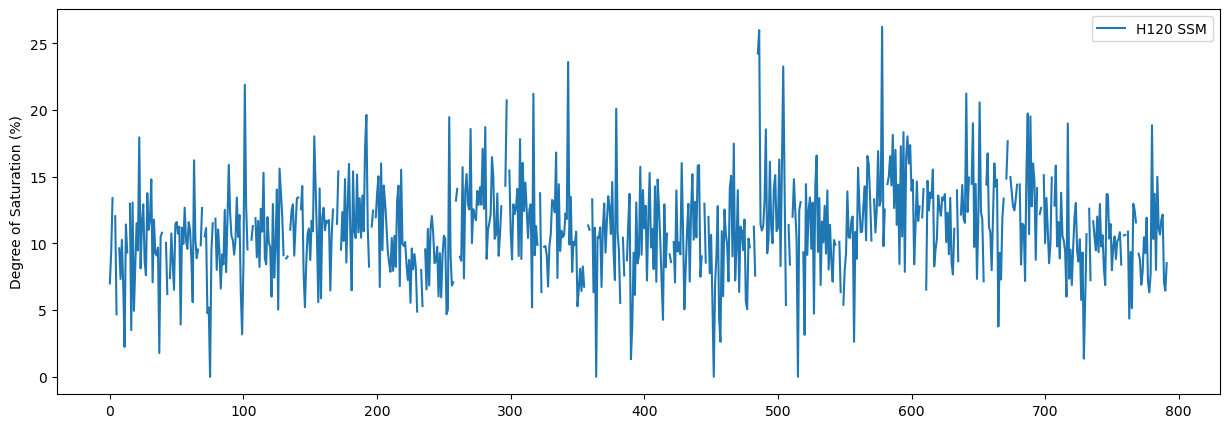

In [116]:
# Show time series subset

h120_ds_filtered = h120_ds.sel(time=slice("2018-01-01", "2018-12-31"))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ds_filtered.surface_soil_moisture, label="H120 SSM")
ax.set_ylabel("Degree of Saturation (%)")
ax.legend()
plt.show()

As discussed in the live session, soil moisture is affected by snow cover and frozen soils. We can see this in the subset of 2018, where a clear drop in soil moisture is visible in March, which is not likely due to changes in soil moisture. 
Hence we mask for frozen soils and snow cover using the probability mask. Please note, this is not the same as masking using in situ data or model data, but only a probability of that these conditions occur.

## Calculate VOD for exercise 2
In exercise 2 you will need an estimate for TAU or the so-called VOD. TAU can be calculated from Metop ASCAT observables and this is done in the code below. VOD is written to the data frame of the ASCAT data, and when you temporally match the data with the ISMN data then you can store the dataframe including VOD.  

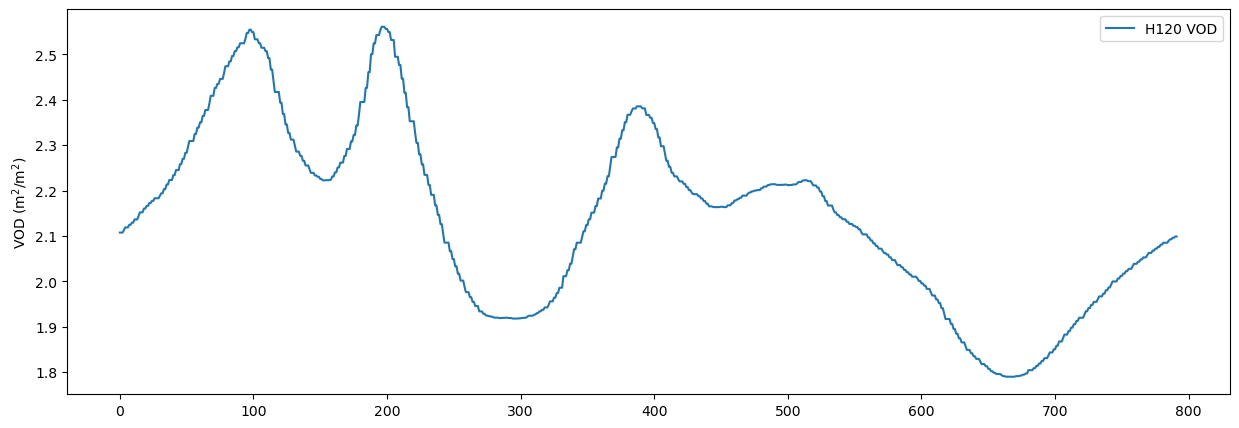

In [117]:
# Convert all backscatter to the dry reference cross over angle of 25 degrees
sig25 = (
    h120_ds.backscatter40
    + h120_ds.slope40 * (25 - 40)
    + 0.5 * h120_ds.curvature40 * (25 - 40) ** 2.0
)

# Get the lowest backscatter (1% in this case)
dry_25 = sig25.quantile(0.01, dim="time")

# Convert to the reference angle of 40 degrees
dry_ref = (
    dry_25 - h120_ds.slope40 * (25 - 40) - 0.5 * h120_ds.curvature40 * (25 - 40) ** 2
)

# Get the wet reference
wet_ref = h120_ds.backscatter40.quantile(0.05, dim="time")

# Set bare soil sensitivity
lin_bs_sens = 0.21

# Convert to linear domain
lin_wet_ref = 10 ** (wet_ref / 10.0)
lin_dry_ref = 10 ** (dry_ref / 10.0)

# Get total backscatter sensitivity
lin_sens = lin_wet_ref - lin_dry_ref
inc_angle = -np.cos(np.radians(40)) / 2.0

# Calculate vod as ratio between bare soil sensitivity
# and total backscatter sensitivity and store it in the h120 xarray
h120_ds["vod"] = inc_angle * np.log(lin_sens / lin_bs_sens)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ds.sel(time=slice("2018-01-01", "2018-12-31")).vod, label="H120 VOD")
ax.set_ylabel(r"VOD (m$^2$/m$^2$)")
ax.legend()
plt.show()

## Temporal matching
The data of the in situ station and the satellite observations do not match, e.g. the satellite data is available from 2007 to 2022, the in situ station only since 2014 in my case, the observation times are different with satellite observation irregular between 6 and 10 AM/PM and the in situ data at hourly intervals. So these two datasets need to be matched in time in order to have the same amount of observations. Here it is best practice to match to the most sparse dataset, in our case the ASCAT data.

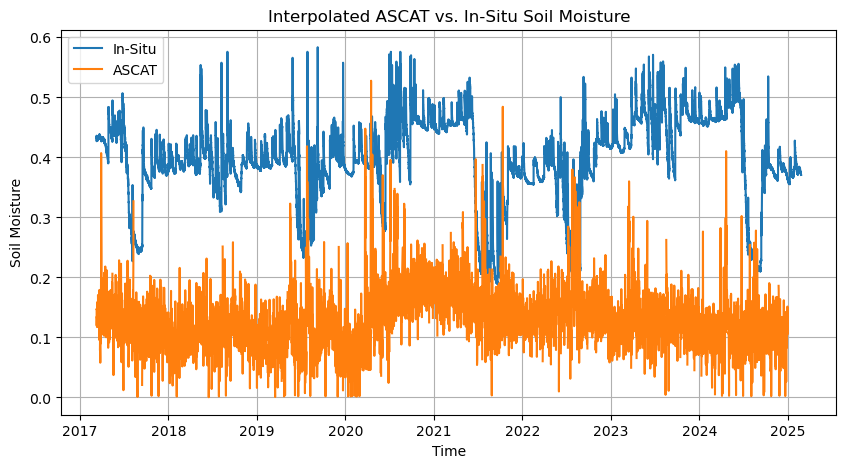

In [89]:
h120_interp = h120_ds.interp(time=insitu_ds.date_time, method="linear")

plt.figure(figsize=(10, 5))

insitu_ds.soil_moisture.plot(label="In-Situ")

plt.plot(h120_interp.date_time, h120_interp.surface_soil_moisture / 100, label="ASCAT")

plt.xlabel("Time")
plt.ylabel("Soil Moisture")
plt.legend()
plt.title("Interpolated ASCAT vs. In-Situ Soil Moisture")
plt.grid()
plt.show()

In [90]:
# Find common date range
start_date = max(insitu_ds.date_time.min(), h120_ds.time.min())
end_date = min(insitu_ds.date_time.max(), h120_ds.time.max())

# Clip datasets to this range
insitu_ds_clipped = insitu_ds.sel(date_time=slice(start_date, end_date))
h120_interp_clipped = h120_interp.sel(date_time=slice(start_date, end_date))


<Figure size 1400x400 with 0 Axes>

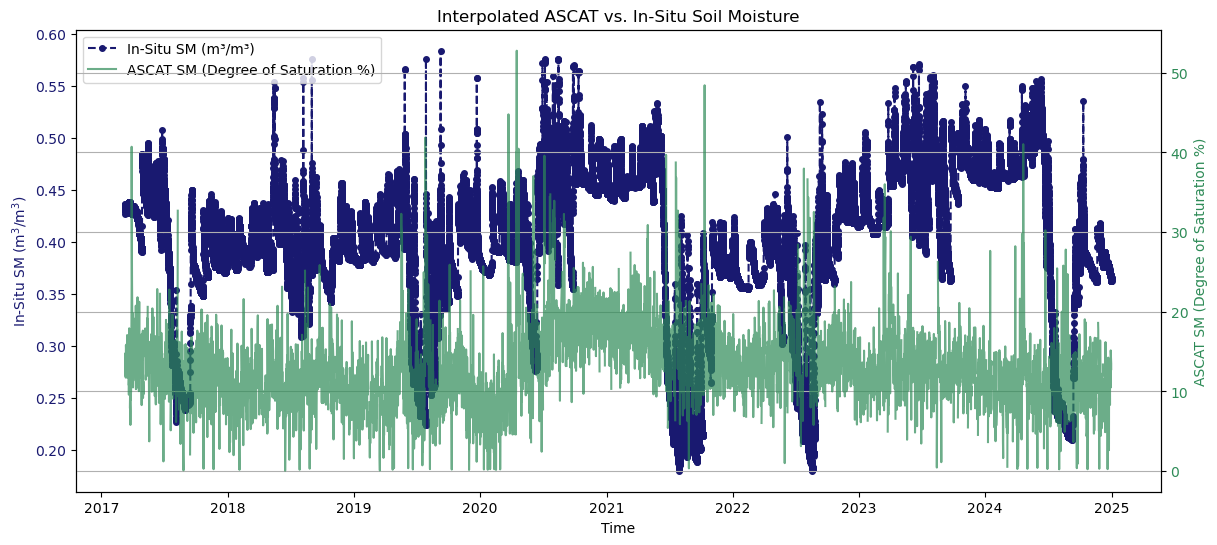

In [91]:
plt.figure(figsize=(14, 4))
fig, ax1 = plt.subplots(figsize=(14, 6))

# In-Situ Soil Moisture in m³/m³
lns1 = ax1.plot(
    insitu_ds_clipped.date_time,
    insitu_ds_clipped.soil_moisture,
    label="In-Situ SM (m³/m³)",
    color="midnightblue",
    marker="o",
    markersize=4,
    linestyle="--",
)
ax1.set_xlabel("Time")
ax1.set_ylabel(r"In-Situ SM (m$^3$/m$^3$)", color="midnightblue")
ax1.tick_params(axis="y", labelcolor="midnightblue")

# ASCAT Soil Moisture in % Degree of Saturation
ax2 = ax1.twinx()
lns2 = ax2.plot(
    h120_interp.date_time,
    h120_interp.surface_soil_moisture,
    label="ASCAT SM (Degree of Saturation %)",
    color="seagreen",
    linestyle="-",
    alpha=0.7,
)
ax2.set_ylabel("ASCAT SM (Degree of Saturation %)", color="seagreen")
ax2.tick_params(axis="y", labelcolor="seagreen")

# Combine Legends from Both Axes
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc="upper left")

plt.title("Interpolated ASCAT vs. In-Situ Soil Moisture")
plt.grid()
plt.show()

Keep in mind that all variables are now in one dataset, where soil_moisture stands for in situ data, while sm for ASCAT data. Therefore, we should rename variables for convenience.

In [92]:
merged_ds = xr.merge([insitu_ds.squeeze(), h120_interp]).rename(
    {"soil_moisture": "SM_insitu", "surface_soil_moisture": "SM_ascat"}
)
merged_ds

<xarray.Dataset> Size: 14MB
Dimensions:                            (date_time: 69376)
Coordinates:
  * date_time                          (date_time) datetime64[ns] 555kB 2017-...
    lon                                float32 4B ...
    lat                                float32 4B ...
    alt                                float32 4B ...
    time                               (date_time) datetime64[ns] 555kB 2017-...
Data variables: (12/47)
    SM_insitu                          (date_time) float64 555kB 0.43 ... 0.3708
    soil_moisture_flag                 (date_time) object 555kB 'G' 'G' ... 'G'
    soil_moisture_orig_flag            (date_time) object 555kB 'M' 'M' ... 'M'
    depth_from                         float64 8B 0.2
    depth_to                           float64 8B 0.2
    clay_fraction                      float64 8B 20.0
    ...                                 ...
    frozen_soil_probability            (date_time) float64 555kB 0.0 0.0 ... nan
    wetland_fraction                   (date_time) float64 555kB 0.0 0.0 ... nan
    topographic_complexity             (date_time) float64 555kB 1.0 1.0 ... nan
    subsurface_scattering_probability  (date_time) float64 555kB 33.0 ... nan
    sat_id                             (date_time) float64 555kB 3.0 3.0 ... nan
    vod                                (date_time) float64 555kB 2.226 ... nan

Lets save the data to load it for other notebooks. The most convenient format is zarr.

In [93]:
merged_ds.to_zarr("merged_soilmoisture_vod.zarr", mode="w")

## Exercise
To complete the exercise, please locate an ISMN station of your interest, download the ISMN data, read in the data using the longitude and latitude. Do a temporal matching of the data and plot the time series as shown below and upload this to the Padlet with a description and first interpretation. If necessary, save your matched dataframe (see below) so you have it ready for the other exercises.